# Анализ системы метрик приложения



Ваши задачи:
- провести анализ юнит-экономики продукта в динамике за первые 28 дней;
- разобраться в причинах стагнации выручки;
- определить, какие источники привлечения приносят прибыль, а какие не выходят на уровень окупаемости;
- дать рекомендации отделу маркетинга.


### Данные

В вашем распоряжении есть данные о посещениях приложения, покупках и расходах на маркетинг.
Данные собраны в трёх датасетах.

1. Датасет `ppro_visits.csv` — информация о посещениях приложения пользователями, которые зарегистрировались с 1 апреля 2024 года по 30 ноября 2024 года:
    - `user_id` — уникальный идентификатор пользователя;
    - `region` — страна пользователя;
    - `device` — категория устройства пользователя;
    - `channel` — идентификатор рекламного источника, из которого пришёл пользователь;
    - `session_start` — дата и время начала сессии;
    - `session_end` — дата и время окончания сессии.

2. Датасет `ppro_orders.csv` — информация о покупках:
    - `user_id` — уникальный идентификатор пользователя, который сделал покупку;
    - `event_dt` — дата и время покупки;
    - `revenue` — выручка.

3. Датасет `ppro_costs.csv` — информация о затратах на маркетинг:
    - `dt` — дата
    - `channel` — идентификатор рекламного источника;
    - `costs` — затраты на этот рекламный источник в этот день.
    
### План проекта
- Загрузить и предобработать данные.
- Подготовить данные для когортного анализа.
- Рассчитать и проанализировать метрики вовлечённости в продукт.
- Рассчитать и проанализировать финансовые метрики CAC, LTV и ROI за первые 28 дней с момента привлечения.
- Исследовать метрики в разрезе источника привлечения.
- Рассчитать период окупаемости маркетинговых вложений.
- Сформулировать выводы и рекомендации.


## Загрузка и предобработка данных

Загрузите данные и получите основную информацию о них. Проведите необходимую предобработку. Основную информацию о данных и предобработке зафиксируйте в кратком промежуточном выводе.

In [1]:
# импортируем библиотеки
import pandas as pd
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# выыодим датасет с информацией о посещениях приложения пользователями
df_visits = pd.read_csv('')
df_visits.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161865 entries, 0 to 161864
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        161865 non-null  int64 
 1   region         161865 non-null  object
 2   device         161865 non-null  object
 3   channel        161865 non-null  object
 4   session_start  161865 non-null  object
 5   session_end    161865 non-null  object
dtypes: int64(1), object(5)
memory usage: 7.4+ MB


In [3]:
display(df_visits)

,user_id,region,device,channel,session_start,session_end
0,631105188566,India,desktop,MediaTornado,2024-04-01 03:48:00,2024-04-01 04:19:00
1,892885906464,India,tv,RocketSuperAds,2024-04-01 00:47:00,2024-04-01 01:14:00
2,517003690029,India,mobile,MediaTornado,2024-04-01 17:31:00,2024-04-01 17:53:00
3,185156659289,India,mobile,MediaTornado,2024-04-01 14:36:00,2024-04-01 14:51:00
4,409503040345,India,mobile,RocketSuperAds,2024-04-01 08:25:00,2024-04-01 08:45:00
...,...,...,...,...,...,...
161860,173722594460,India,desktop,MediaTornado,2024-11-30 02:12:00,2024-11-30 02:40:00
161861,711873273862,India,mobile,FaceBoom,2024-11-30 05:31:00,2024-11-30 05:55:00
161862,797604836232,India,mobile,TipTop,2024-11-30 09:55:00,2024-11-30 09:56:00
161863,188139897674,India,desktop,MediaTornado,2024-11-30 02:12:00,2024-11-30 02:36:00


In [4]:
# Преобразуем даты в корректный формат
df_visits['session_start'] = pd.to_datetime(df_visits['session_start'])
df_visits['session_end'] = pd.to_datetime(df_visits['session_end'])
df_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161865 entries, 0 to 161864
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        161865 non-null  int64         
 1   region         161865 non-null  object        
 2   device         161865 non-null  object        
 3   channel        161865 non-null  object        
 4   session_start  161865 non-null  datetime64[ns]
 5   session_end    161865 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 7.4+ MB


In [5]:
# выыодим датасет с информацией о покупках
df_orders = pd.read_csv('')
df_orders.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33893 entries, 0 to 33892
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   33893 non-null  int64  
 1   event_dt  33893 non-null  object 
 2   revenue   33893 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 794.5+ KB


In [6]:
display(df_orders)

,user_id,event_dt,revenue
0,771951256319,2024-04-01 05:56:26,2.99
1,829942381059,2024-04-01 14:55:02,2.99
2,727879856738,2024-04-01 22:15:09,14.99
3,481270888930,2024-04-01 06:05:14,2.99
4,844695029762,2024-04-01 01:19:52,2.99
...,...,...,...
33888,397577560536,2024-11-30 16:47:45,2.99
33889,610390409217,2024-11-30 04:35:45,7.99
33890,74116424793,2024-11-30 04:16:46,2.99
33891,691138256176,2024-11-30 02:07:03,2.99


In [7]:
# Преобразуем даты в корректный формат
df_orders['event_dt'] = pd.to_datetime(df_orders['event_dt'])
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33893 entries, 0 to 33892
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   33893 non-null  int64         
 1   event_dt  33893 non-null  datetime64[ns]
 2   revenue   33893 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 794.5 KB


In [8]:
# выыодим датасет с информацией о затратах на маркетинг
df_costs = pd.read_csv('')
df_costs.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       976 non-null    object 
 1   channel  976 non-null    object 
 2   costs    976 non-null    float64
dtypes: float64(1), object(2)
memory usage: 23.0+ KB


In [9]:
display(df_costs)

,dt,channel,costs
0,2024-04-01,FaceBoom,124.938874
1,2024-04-02,FaceBoom,88.147779
2,2024-04-03,FaceBoom,120.779457
3,2024-04-04,FaceBoom,98.981253
4,2024-04-05,FaceBoom,109.044760
...,...,...,...
971,2024-11-26,TipTop,216.741490
972,2024-11-27,TipTop,263.071019
973,2024-11-28,TipTop,252.638555
974,2024-11-29,TipTop,261.943208


In [10]:
# Преобразуем даты в корректный формат
df_costs['dt'] = pd.to_datetime(df_costs['dt'])
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       976 non-null    datetime64[ns]
 1   channel  976 non-null    object        
 2   costs    976 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 23.0+ KB


Вывели информацию по датафреймам и перевели даты в корректный формат.

## Подготовка данных к когортному анализу



In [11]:
# Находим дату и канал привлечения для каждого пользователя
first_visits = df_visits.sort_values('session_start').groupby('user_id').first().reset_index()
profiles = first_visits[['user_id', 'session_start', 'channel']].copy()
profiles.columns = ['user_id', 'first_dt', 'first_channel']
profiles['first_date'] = profiles['first_dt'].dt.date

In [12]:
# Подготовка данных о затратах
daily_costs = df_costs.groupby(['dt', 'channel'])['costs'].sum().reset_index()
daily_costs['date'] = daily_costs['dt'].dt.date

# Подготовка данных о новых пользователях
daily_users = df_visits.groupby([df_visits['session_start'].dt.date, 'channel'])['user_id'].nunique().reset_index()
daily_users.columns = ['date', 'channel', 'new_users']

# Расчет дневного CAC по каналам
daily_cac = daily_costs.merge(daily_users, on=['date', 'channel'], how='left')
daily_cac['daily_cac'] = daily_cac['costs'] / daily_cac['new_users']

# Заполняем пропуски (если нет пользователей в какой-то день)
daily_cac['daily_cac'] = daily_cac['daily_cac'].fillna(0)

print("Дневной CAC по каналам:")
display(daily_cac.head())

# Присваиваем CAC каждому пользователю
profiles = profiles.merge(
    daily_cac[['date', 'channel', 'daily_cac']],
    left_on=['first_date', 'first_channel'],
    right_on=['date', 'channel'],
    how='left'
)

# Обработка случаев, когда нет данных о затратах
# Для таких пользователей используем средний CAC по каналу
avg_cac_by_channel = daily_cac.groupby('channel')['daily_cac'].mean().reset_index()
profiles = profiles.merge(
    avg_cac_by_channel,
    left_on='first_channel',
    right_on='channel',
    how='left',
    suffixes=('', '_avg')
)

# Заполняем пропуски: сначала точный daily_cac, потом средний по каналу
profiles['cac'] = profiles['daily_cac'].fillna(profiles['daily_cac_avg'])

# Если все еще есть пропуски, используем общий средний CAC
if profiles['cac'].isnull().any():
    overall_avg_cac = daily_cac['daily_cac'].mean()
    profiles['cac'] = profiles['cac'].fillna(overall_avg_cac)

# Финализируем таблицу
profiles = profiles[['user_id', 'first_dt', 'first_channel', 'cac']]

print("Результат - CAC для каждого пользователя:")
print(f"Всего пользователей: {len(profiles)}")
print(f"Пользователей с CAC > 0: {(profiles['cac'] > 0).sum()}")
print(f"Средний CAC: {profiles['cac'].mean():.2f}")
print(f"Минимальный CAC: {profiles['cac'].min():.2f}")
print(f"Максимальный CAC: {profiles['cac'].max():.2f}")

display(profiles.head(10))

Дневной CAC по каналам:


,dt,channel,costs,date,new_users,daily_cac
0,2024-04-01,FaceBoom,124.938874,2024-04-01,133,0.939390
1,2024-04-01,MediaTornado,19.932806,2024-04-01,80,0.249160
2,2024-04-01,RocketSuperAds,62.050000,2024-04-01,70,0.886429
3,2024-04-01,TipTop,54.200101,2024-04-01,73,0.742467
4,2024-04-02,FaceBoom,88.147779,2024-04-02,113,0.780069


Результат - CAC для каждого пользователя:
Всего пользователей: 74856
Пользователей с CAC > 0: 74856
Средний CAC: 0.55
Минимальный CAC: 0.08
Максимальный CAC: 1.06


,user_id,first_dt,first_channel,cac
0,26034876,2024-05-29 10:24:00,FaceBoom,0.752566
1,69890364,2024-06-28 05:48:00,RocketSuperAds,0.246905
2,75610104,2024-06-09 06:48:00,FaceBoom,0.922230
3,76692397,2024-10-21 01:51:00,FaceBoom,0.802913
4,80224421,2024-06-21 11:47:00,FaceBoom,0.978320
5,107763096,2024-07-28 14:25:00,TipTop,0.511286
6,118088465,2024-07-05 20:56:00,TipTop,0.599408
7,135740994,2024-09-18 07:29:00,FaceBoom,0.926876
8,147323613,2024-07-02 01:04:00,MediaTornado,0.124103
9,153870476,2024-05-04 05:51:00,FaceBoom,0.797236


In [13]:
# Шаг 1: Рассчитываем лайфтайм для каждой покупки
orders_with_lifetime = df_orders.merge(
    profiles[['user_id', 'first_dt']],
    on='user_id',
    how='left'
)

orders_with_lifetime['purchase_lifetime_days'] = (
    orders_with_lifetime['event_dt'] - orders_with_lifetime['first_dt']
).dt.days

# Шаг 2: Находим максимальный лайфтайм покупки для каждого пользователя
user_max_lifetime = orders_with_lifetime.groupby('user_id')['purchase_lifetime_days'].max().reset_index()
user_max_lifetime.columns = ['user_id', 'max_purchase_lifetime']

# Шаг 3: Добавляем в таблицу profiles
profiles = profiles.merge(
    user_max_lifetime,
    on='user_id',
    how='left'
)

# Заполняем пропуски для пользователей без покупок
profiles['max_purchase_lifetime'] = profiles['max_purchase_lifetime'].fillna(0).astype(int)
display(profiles)

,user_id,first_dt,first_channel,cac,max_purchase_lifetime
0,26034876,2024-05-29 10:24:00,FaceBoom,0.752566,0
1,69890364,2024-06-28 05:48:00,RocketSuperAds,0.246905,0
2,75610104,2024-06-09 06:48:00,FaceBoom,0.922230,0
3,76692397,2024-10-21 01:51:00,FaceBoom,0.802913,0
4,80224421,2024-06-21 11:47:00,FaceBoom,0.978320,1
...,...,...,...,...,...
74851,999956504962,2024-07-04 08:38:00,MediaTornado,0.138511,0
74852,999959994517,2024-06-03 13:01:00,RocketSuperAds,0.235473,0
74853,999962248443,2024-10-27 14:41:00,RocketSuperAds,0.158703,0
74854,999970372492,2024-08-07 19:54:00,TipTop,0.644934,90


Создали таблицу с данными пользователей о дате первой сессии, первом канале привлечения и затраты на привлечение пользователя, а также расчитали дневной лайфтайм.

## Анализ месячной динамики основных метрик продукта



In [14]:
# Создаем колонку с датой для группировки
df_visits['date'] = df_visits['session_start'].dt.date
df_visits['month'] = df_visits['session_start'].dt.to_period('M')

In [15]:
# DAU - уникальные пользователи в день
dau = df_visits.groupby('date')['user_id'].nunique().reset_index()
dau.columns = ['date', 'dau']
dau['date'] = pd.to_datetime(dau['date'])

print("Статистика DAU:")
print(dau['dau'].describe())

Статистика DAU:
count    244.000000
mean     663.381148
std      122.694233
min      356.000000
25%      568.000000
50%      657.500000
75%      755.250000
max      933.000000
Name: dau, dtype: float64


In [16]:
# MAU - уникальные пользователи в месяц
mau = df_visits.groupby('month')['user_id'].nunique().reset_index()
mau.columns = ['month', 'mau']
mau['month'] = mau['month'].astype(str)

print("Статистика MAU:")
print(mau['mau'].describe())

Статистика MAU:
count        8.000000
mean     11527.625000
std       1603.465349
min       9069.000000
25%      10696.750000
50%      11420.500000
75%      12325.750000
max      14097.000000
Name: mau, dtype: float64


In [17]:
# Для расчета Stickiness нужно сопоставить DAU с соответствующим месяцем
df_visits['month_str'] = df_visits['month'].astype(str)
month_mapping = df_visits[['date', 'month_str']].drop_duplicates()
month_mapping['date'] = pd.to_datetime(month_mapping['date'])

# Объединяем DAU с информацией о месяце
dau_with_month = dau.merge(month_mapping, on='date', how='left')

# Рассчитываем средний DAU по месяцам
avg_dau_by_month = dau_with_month.groupby('month_str')['dau'].mean().reset_index()
avg_dau_by_month.columns = ['month', 'avg_dau']

# Объединяем с MAU для расчета Stickiness
stickiness = avg_dau_by_month.merge(mau, on='month', how='left')
stickiness['stickiness'] = stickiness['avg_dau'] / stickiness['mau']

print("Stickiness по месяцам:")
print(stickiness[['month', 'stickiness']])

Stickiness по месяцам:
     month  stickiness
0  2024-04    0.053846
1  2024-05    0.053182
2  2024-06    0.056676
3  2024-07    0.056609
4  2024-08    0.056875
5  2024-09    0.059897
6  2024-10    0.059312
7  2024-11    0.061583


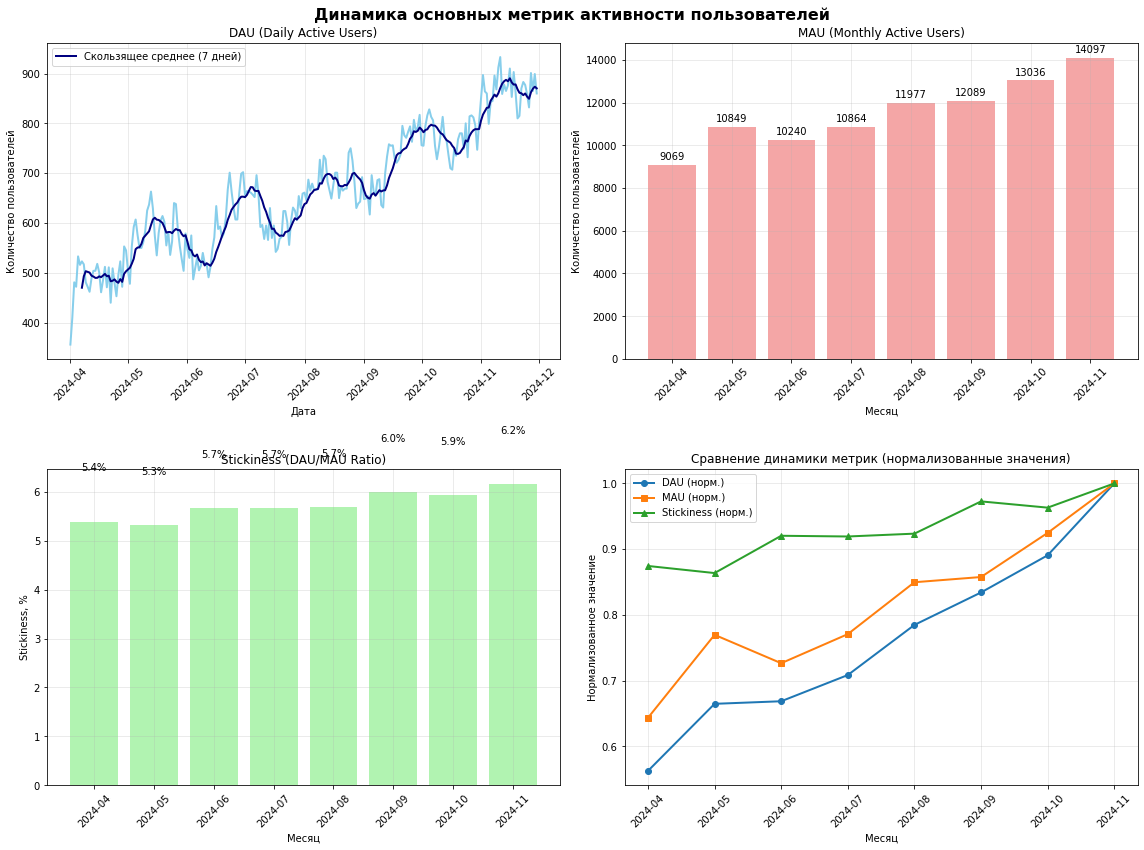

In [18]:
# Создаем фигуру с несколькими subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Динамика основных метрик активности пользователей', fontsize=16, fontweight='bold')

# 1. График DAU
ax1.plot(dau['date'], dau['dau'], linewidth=2, color='skyblue')
ax1.set_title('DAU (Daily Active Users)')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Количество пользователей')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Добавляем скользящее среднее для DAU
dau['dau_ma_7'] = dau['dau'].rolling(window=7).mean()
ax1.plot(dau['date'], dau['dau_ma_7'], linewidth=2, color='navy', label='Скользящее среднее (7 дней)')
ax1.legend()

# 2. График MAU
ax2.bar(range(len(mau)), mau['mau'], color='lightcoral', alpha=0.7)
ax2.set_title('MAU (Monthly Active Users)')
ax2.set_xlabel('Месяц')
ax2.set_ylabel('Количество пользователей')
ax2.set_xticks(range(len(mau)))
ax2.set_xticklabels(mau['month'], rotation=45)
ax2.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, v in enumerate(mau['mau']):
    ax2.text(i, v + max(mau['mau'])*0.01, str(v), ha='center', va='bottom')

# 3. График Stickiness
ax3.bar(range(len(stickiness)), stickiness['stickiness'] * 100, color='lightgreen', alpha=0.7)
ax3.set_title('Stickiness (DAU/MAU Ratio)')
ax3.set_xlabel('Месяц')
ax3.set_ylabel('Stickiness, %')
ax3.set_xticks(range(len(stickiness)))
ax3.set_xticklabels(stickiness['month'], rotation=45)
ax3.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, v in enumerate(stickiness['stickiness'] * 100):
    ax3.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

# 4. Комбинированный график всех метрик
months = stickiness['month']
x_pos = range(len(months))

# Нормализуем метрики для сравнения в одном масштабе
dau_normalized = dau_with_month.groupby('month_str')['dau'].mean() / dau_with_month.groupby('month_str')['dau'].mean().max()
mau_normalized = mau['mau'] / mau['mau'].max()
stickiness_normalized = stickiness['stickiness'] / stickiness['stickiness'].max()

ax4.plot(x_pos, dau_normalized.values, marker='o', linewidth=2, label='DAU (норм.)')
ax4.plot(x_pos, mau_normalized.values, marker='s', linewidth=2, label='MAU (норм.)')
ax4.plot(x_pos, stickiness_normalized.values, marker='^', linewidth=2, label='Stickiness (норм.)')
ax4.set_title('Сравнение динамики метрик (нормализованные значения)')
ax4.set_xlabel('Месяц')
ax4.set_ylabel('Нормализованное значение')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(months, rotation=45)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

График DAU показывает стабильный рост с сезонными колебаниями. Stickiness Ratio имеет хорошие показатели, более 5% месячных пользователей активны ежедневно. MAU также хорошо растет.

In [19]:
# Находим дату привлечения для каждого пользователя
user_acquisition = df_visits.groupby('user_id')['session_start'].min().reset_index()
user_acquisition.columns = ['user_id', 'acquisition_date']
user_acquisition['acquisition_month'] = user_acquisition['acquisition_date'].dt.to_period('M')

# Добавляем канал привлечения (первый канал пользователя)
first_channel = df_visits.sort_values('session_start').groupby('user_id')['channel'].first().reset_index()
user_acquisition = user_acquisition.merge(first_channel, on='user_id')

In [20]:
# Группируем затраты по месяцам и каналам
df_costs['month'] = df_costs['dt'].dt.to_period('M')
monthly_costs = df_costs.groupby(['month', 'channel'])['costs'].sum().reset_index()

# Считаем количество привлеченных пользователей по месяцам и каналам
monthly_users = user_acquisition.groupby(['acquisition_month', 'channel'])['user_id'].nunique().reset_index()
monthly_users.columns = ['month', 'channel', 'users_count']

# Объединяем затраты и количество пользователей
cac_calculation = monthly_costs.merge(monthly_users, on=['month', 'channel'], how='right')
cac_calculation['cac'] = cac_calculation['costs'] / cac_calculation['users_count']
cac_calculation['cac'] = cac_calculation['cac'].fillna(0)  # Если нет затрат, CAC = 0

# Суммируем CAC по месяцам (агрегируем по каналам)
monthly_cac = cac_calculation.groupby('month').agg(
    total_costs=('costs', 'sum'),
    total_users=('users_count', 'sum'),
    avg_cac=('cac', 'mean')
).reset_index()

print("CAC по месяцам привлечения:")
print(monthly_cac[['month', 'total_users', 'total_costs', 'avg_cac']].round(2))

CAC по месяцам привлечения:
     month  total_users  total_costs  avg_cac
0  2024-04         9069      6663.05     0.70
1  2024-05         9789      7327.78     0.72
2  2024-06         8719      8492.12     0.89
3  2024-07         8742      9217.08     0.95
4  2024-08         9518     10999.01     1.04
5  2024-09         9198     10838.01     1.06
6  2024-10         9520     12595.40     1.17
7  2024-11        10301     13598.85     1.17


In [21]:
# Добавляем дату привлечения к заказам
orders_with_acquisition = df_orders.merge(user_acquisition[['user_id', 'acquisition_date', 'acquisition_month']], on='user_id')

# Рассчитываем лайфтайм для каждого заказа
orders_with_acquisition['lifetime_days'] = (orders_with_acquisition['event_dt'] - orders_with_acquisition['acquisition_date']).dt.days

# Фильтруем заказы за первые 28 дней
orders_28_days = orders_with_acquisition[orders_with_acquisition['lifetime_days'] < 28]

# Рассчитываем LTV по месяцам привлечения
ltv_calculation = orders_28_days.groupby('acquisition_month').agg(
    total_revenue=('revenue', 'sum'),
    paying_users=('user_id', 'nunique')
).reset_index()

# Добавляем общее количество пользователей в когорте
cohort_sizes = user_acquisition.groupby('acquisition_month')['user_id'].nunique().reset_index()
cohort_sizes.columns = ['acquisition_month', 'total_users']

ltv_calculation = ltv_calculation.merge(cohort_sizes, on='acquisition_month', how='left')
ltv_calculation['ltv'] = ltv_calculation['total_revenue'] / ltv_calculation['total_users']
ltv_calculation['arpu'] = ltv_calculation['total_revenue'] / ltv_calculation['paying_users']

print("LTV по месяцам привлечения (28 дней):")
print(ltv_calculation[['acquisition_month', 'total_users', 'paying_users', 'total_revenue', 'ltv', 'arpu']].round(2))

LTV по месяцам привлечения (28 дней):
  acquisition_month  total_users  paying_users  total_revenue   ltv   arpu
0           2024-04         9069           777        7476.47  0.82   9.62
1           2024-05         9789           857        8182.65  0.84   9.55
2           2024-06         8719           757        7506.16  0.86   9.92
3           2024-07         8742           903       10060.27  1.15  11.14
4           2024-08         9518           881       10445.32  1.10  11.86
5           2024-09         9198           844       10145.70  1.10  12.02
6           2024-10         9520           897       11524.47  1.21  12.85
7           2024-11        10301           918        8896.97  0.86   9.69


In [22]:
# Объединяем CAC и LTV данные
roi_calculation = monthly_cac.merge(ltv_calculation, left_on='month', right_on='acquisition_month', how='left')

# Рассчитываем ROI
roi_calculation['roi'] = (roi_calculation['total_revenue'] - roi_calculation['total_costs']) / roi_calculation['total_costs'] * 100
roi_calculation['roi_per_user'] = (roi_calculation['ltv'] - roi_calculation['avg_cac']) / roi_calculation['avg_cac'] * 100
roi_calculation['profit'] = roi_calculation['total_revenue'] - roi_calculation['total_costs']
roi_calculation['profit_per_user'] = roi_calculation['ltv'] - roi_calculation['avg_cac']

# Заполняем пропуски (если нет затрат или revenue)
roi_calculation['roi'] = roi_calculation['roi'].fillna(0)
roi_calculation['profit'] = roi_calculation['profit'].fillna(0)

print("ROI по месяцам привлечения (28 дней):")
print(roi_calculation[['month', 'total_costs', 'total_revenue', 'profit', 'avg_cac', 'ltv', 'roi']].round(2))

ROI по месяцам привлечения (28 дней):
     month  total_costs  total_revenue   profit  avg_cac   ltv    roi
0  2024-04      6663.05        7476.47   813.42     0.70  0.82  12.21
1  2024-05      7327.78        8182.65   854.87     0.72  0.84  11.67
2  2024-06      8492.12        7506.16  -985.96     0.89  0.86 -11.61
3  2024-07      9217.08       10060.27   843.19     0.95  1.15   9.15
4  2024-08     10999.01       10445.32  -553.69     1.04  1.10  -5.03
5  2024-09     10838.01       10145.70  -692.31     1.06  1.10  -6.39
6  2024-10     12595.40       11524.47 -1070.93     1.17  1.21  -8.50
7  2024-11     13598.85        8896.97 -4701.88     1.17  0.86 -34.58


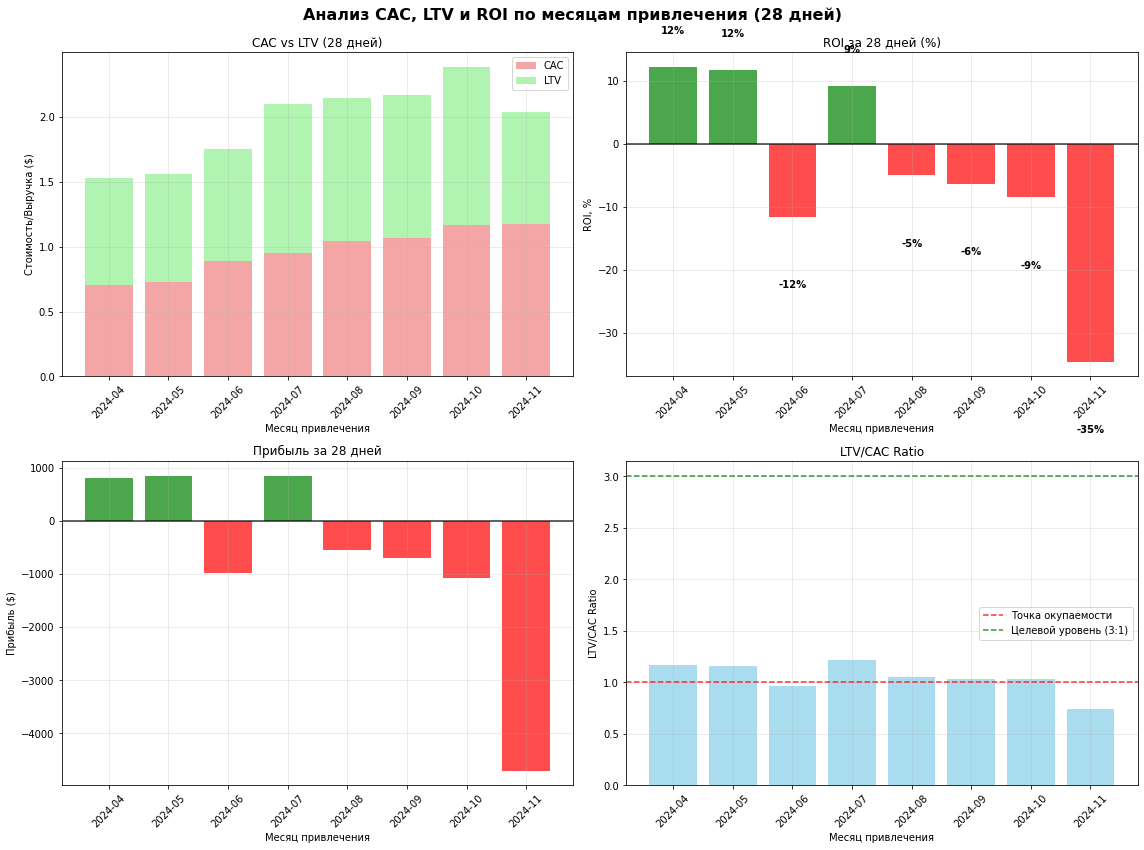

In [23]:
# Создаем комплексную визуализацию
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Анализ CAC, LTV и ROI по месяцам привлечения (28 дней)', fontsize=16, fontweight='bold')

# 1. График CAC и LTV
months = roi_calculation['month'].astype(str)
x_pos = range(len(months))

ax1.bar(x_pos, roi_calculation['avg_cac'], alpha=0.7, label='CAC', color='lightcoral')
ax1.bar(x_pos, roi_calculation['ltv'], alpha=0.7, label='LTV', color='lightgreen', bottom=roi_calculation['avg_cac'])
ax1.set_title('CAC vs LTV (28 дней)')
ax1.set_xlabel('Месяц привлечения')
ax1.set_ylabel('Стоимость/Выручка ($)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(months, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. График ROI
colors = ['red' if x < 0 else 'green' for x in roi_calculation['roi']]
bars = ax2.bar(x_pos, roi_calculation['roi'], color=colors, alpha=0.7)
ax2.set_title('ROI за 28 дней (%)')
ax2.set_xlabel('Месяц привлечения')
ax2.set_ylabel('ROI, %')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(months, rotation=45)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.8)
ax2.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, v in enumerate(roi_calculation['roi']):
    ax2.text(i, v + (5 if v >= 0 else -10), f'{v:.0f}%', 
             ha='center', va='bottom' if v >= 0 else 'top', fontweight='bold')

# 3. График прибыли
profit_colors = ['red' if x < 0 else 'green' for x in roi_calculation['profit']]
bars = ax3.bar(x_pos, roi_calculation['profit'], color=profit_colors, alpha=0.7)
ax3.set_title('Прибыль за 28 дней')
ax3.set_xlabel('Месяц привлечения')
ax3.set_ylabel('Прибыль ($)')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(months, rotation=45)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.8)
ax3.grid(True, alpha=0.3)

# 4. График LTV/CAC Ratio
roi_calculation['ltv_cac_ratio'] = roi_calculation['ltv'] / roi_calculation['avg_cac']
ax4.bar(x_pos, roi_calculation['ltv_cac_ratio'], color='skyblue', alpha=0.7)
ax4.set_title('LTV/CAC Ratio')
ax4.set_xlabel('Месяц привлечения')
ax4.set_ylabel('LTV/CAC Ratio')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(months, rotation=45)
ax4.axhline(y=1, color='red', linestyle='--', alpha=0.8, label='Точка окупаемости')
ax4.axhline(y=3, color='green', linestyle='--', alpha=0.8, label='Целевой уровень (3:1)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

На всех месяцах привлечения LTV ниже или равно CAC. Это означает, что в среднем мы тратим на привлечение пользователя больше, чем он приносит за первые 28 дней. ROI отрицательный в 5 из 8 месяцев, что подтверждает убыточность привлечения. Пять месяцев показывают отрицательную прибыль. Окупаемость минимальная, а вдвух месяцах вообще не окупилось.

## Анализ метрик в разрезе источника привлечения




In [24]:
# Рассчитываем общий доход от каждого пользователя за 28 дней
user_revenue_28d = df_orders.copy()
user_revenue_28d = user_revenue_28d.merge(profiles[['user_id', 'first_dt']], on='user_id', how='left')

# Фильтруем покупки, сделанные в первые 28 дней
user_revenue_28d['days_since_acquisition'] = (user_revenue_28d['event_dt'] - user_revenue_28d['first_dt']).dt.days
user_revenue_28d = user_revenue_28d[user_revenue_28d['days_since_acquisition'] <= 28]

# Суммируем доход по пользователям
user_ltv = user_revenue_28d.groupby('user_id')['revenue'].sum().reset_index()
user_ltv.columns = ['user_id', 'ltv_28d']

# Добавляем LTV к профилям
profiles = profiles.merge(user_ltv, on='user_id', how='left')
profiles['ltv_28d'] = profiles['ltv_28d'].fillna(0)

# Рассчитываем ROI на уровне пользователя
profiles['roi_28d'] = profiles['ltv_28d'] - profiles['cac']
profiles['roi_percentage'] = (profiles['roi_28d'] / profiles['cac'] * 100).replace([np.inf, -np.inf], 0)

display(profiles.head(10))
print(f"Всего пользователей: {len(profiles)}")
print(f"Пользователей с покупками: {len(profiles[profiles['ltv_28d'] > 0])}")

,user_id,first_dt,first_channel,cac,max_purchase_lifetime,ltv_28d,roi_28d,roi_percentage
0,26034876,2024-05-29 10:24:00,FaceBoom,0.752566,0,0.00,-0.752566,-100.000000
1,69890364,2024-06-28 05:48:00,RocketSuperAds,0.246905,0,0.00,-0.246905,-100.000000
2,75610104,2024-06-09 06:48:00,FaceBoom,0.922230,0,0.00,-0.922230,-100.000000
3,76692397,2024-10-21 01:51:00,FaceBoom,0.802913,0,0.00,-0.802913,-100.000000
4,80224421,2024-06-21 11:47:00,FaceBoom,0.978320,1,2.99,2.011680,205.626006
5,107763096,2024-07-28 14:25:00,TipTop,0.511286,0,0.00,-0.511286,-100.000000
6,118088465,2024-07-05 20:56:00,TipTop,0.599408,113,19.44,18.840592,3143.197810
7,135740994,2024-09-18 07:29:00,FaceBoom,0.926876,0,0.00,-0.926876,-100.000000
8,147323613,2024-07-02 01:04:00,MediaTornado,0.124103,0,0.00,-0.124103,-100.000000
9,153870476,2024-05-04 05:51:00,FaceBoom,0.797236,0,0.00,-0.797236,-100.000000


Всего пользователей: 74856
Пользователей с покупками: 6835


In [25]:
# Группируем по каналам привлечения
channel_performance = profiles.groupby('first_channel').agg(
    total_users=('user_id', 'count'),
    total_cac=('cac', 'sum'),
    total_ltv=('ltv_28d', 'sum'),
    avg_cac=('cac', 'mean'),
    avg_ltv=('ltv_28d', 'mean'),
    paying_users=('ltv_28d', lambda x: (x > 0).sum())
).reset_index()

# Рассчитываем дополнительные метрики
channel_performance['total_roi'] = channel_performance['total_ltv'] - channel_performance['total_cac']
channel_performance['roi_percentage'] = (channel_performance['total_roi'] / channel_performance['total_cac'] * 100).replace([np.inf, -np.inf], 0)
channel_performance['conversion_rate'] = (channel_performance['paying_users'] / channel_performance['total_users'] * 100).round(2)
channel_performance['ltv_cac_ratio'] = channel_performance['avg_ltv'] / channel_performance['avg_cac']

# Сортируем по общим затратам
channel_performance = channel_performance.sort_values('total_cac', ascending=False)

print("Эффективность каналов привлечения за 28 дней:")
display(channel_performance[['first_channel', 'total_users', 'total_cac', 'total_ltv', 'total_roi', 
                           'avg_cac', 'avg_ltv', 'roi_percentage', 'conversion_rate', 'ltv_cac_ratio']].round(2))

Эффективность каналов привлечения за 28 дней:


,first_channel,total_users,total_cac,total_ltv,total_roi,avg_cac,avg_ltv,roi_percentage,conversion_rate,ltv_cac_ratio
0,FaceBoom,28401,24793.71,14605.85,-10187.86,0.87,0.51,-41.09,10.57,0.59
3,TipTop,18118,10598.27,34036.53,23438.26,0.58,1.88,221.15,11.48,3.21
2,RocketSuperAds,14257,3769.66,20561.27,16791.61,0.26,1.44,445.44,7.81,5.45
1,MediaTornado,14080,1757.35,5782.65,4025.30,0.12,0.41,229.05,4.54,3.29


Топ-5 каналов по количеству привлеченных пользователей:


,channel,user_count,percentage
0,FaceBoom,28401,37.94
1,TipTop,18118,24.20
2,RocketSuperAds,14257,19.05
3,MediaTornado,14080,18.81


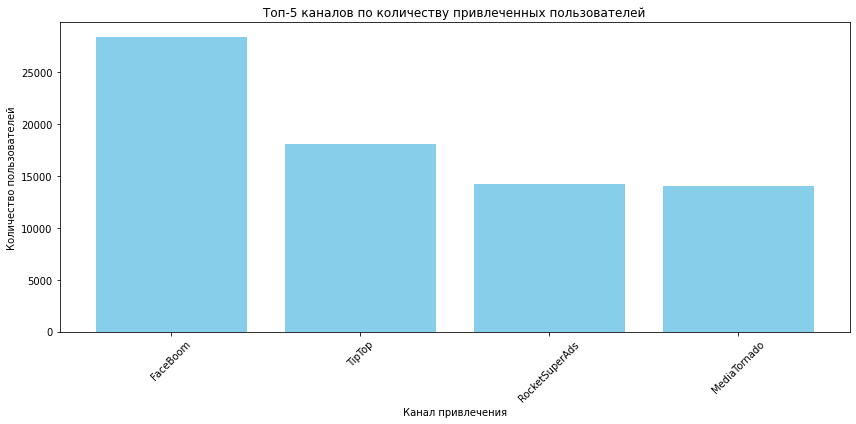

In [26]:
# Общее число привлеченных пользователей по источникам
channel_users = profiles['first_channel'].value_counts().reset_index()
channel_users.columns = ['channel', 'user_count']
channel_users['percentage'] = (channel_users['user_count'] / channel_users['user_count'].sum() * 100).round(2)

print("Топ-5 каналов по количеству привлеченных пользователей:")
display(channel_users.head(5))

# Визуализация
plt.figure(figsize=(12, 6))
plt.bar(channel_users.head(15)['channel'], channel_users.head(15)['user_count'], color='skyblue')
plt.title('Топ-5 каналов по количеству привлеченных пользователей')
plt.xlabel('Канал привлечения')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

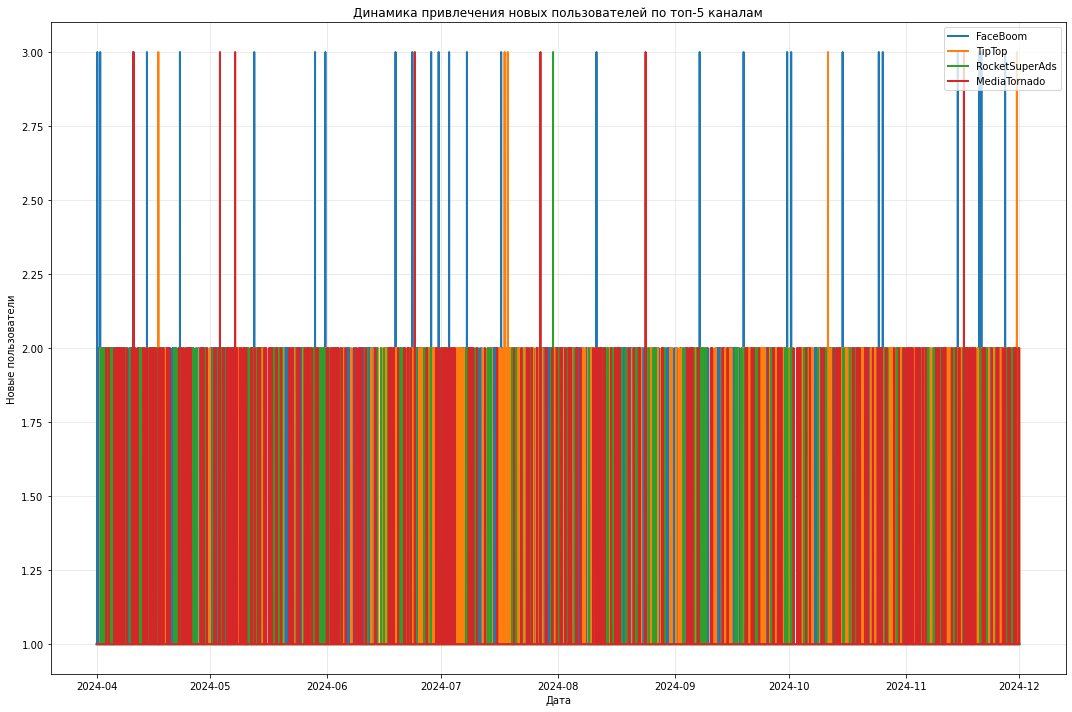

In [27]:
# Динамика привлечения новых пользователей по источникам
new_users_channel = profiles.groupby(['first_dt', 'first_channel'])['user_id'].nunique().reset_index()
new_users_channel.columns = ['date', 'channel', 'new_users']

# Топ-5 каналов для визуализации
top_5_channels = channel_users.head(5)['channel'].tolist()

# Визуализация динамики
plt.figure(figsize=(15, 10))
for channel in top_5_channels:
    channel_data = new_users_channel[new_users_channel['channel'] == channel]
    plt.plot(channel_data['date'], channel_data['new_users'], label=channel, linewidth=2)

plt.title('Динамика привлечения новых пользователей по топ-5 каналам')
plt.xlabel('Дата')
plt.ylabel('Новые пользователи')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

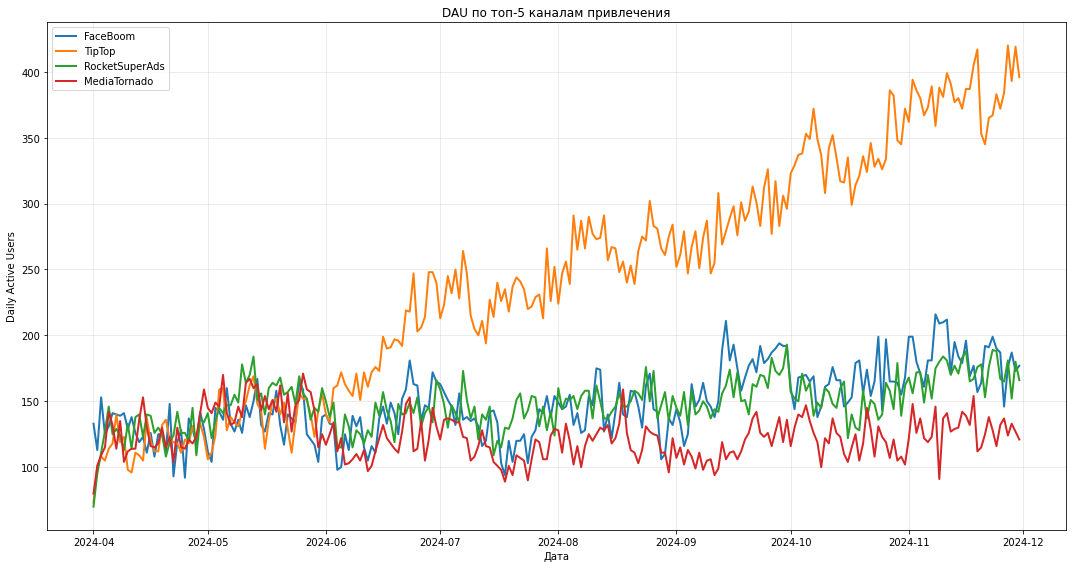

In [28]:
# Подготовка данных для DAU по каналам
visits_with_channel = df_visits.merge(profiles[['user_id', 'first_channel']], on='user_id', how='left')
visits_with_channel['date'] = visits_with_channel['session_start'].dt.date

# Расчет DAU по каналам
dau_by_channel = visits_with_channel.groupby(['date', 'first_channel'])['user_id'].nunique().reset_index()
dau_by_channel.columns = ['date', 'channel', 'dau']

# Визуализация DAU для топ-5 каналов
plt.figure(figsize=(15, 8))
for channel in top_5_channels:
    channel_data = dau_by_channel[dau_by_channel['channel'] == channel]
    plt.plot(channel_data['date'], channel_data['dau'], label=channel, linewidth=2)

plt.title('DAU по топ-5 каналам привлечения')
plt.xlabel('Дата')
plt.ylabel('Daily Active Users')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

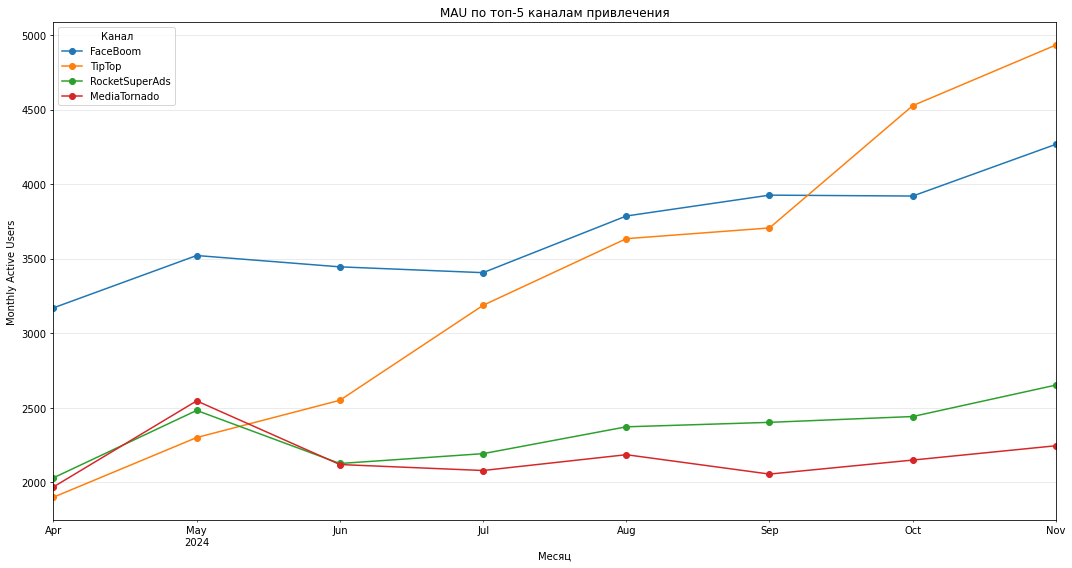

In [29]:
# Расчет MAU по каналам
visits_with_channel['month'] = visits_with_channel['session_start'].dt.to_period('M')
mau_by_channel = visits_with_channel.groupby(['month', 'first_channel'])['user_id'].nunique().reset_index()
mau_by_channel.columns = ['month', 'channel', 'mau']

# Визуализация MAU
mau_pivot = mau_by_channel.pivot(index='month', columns='channel', values='mau')
mau_pivot[top_5_channels].plot(kind='line', figsize=(15, 8), marker='o')
plt.title('MAU по топ-5 каналам привлечения')
plt.xlabel('Месяц')
plt.ylabel('Monthly Active Users')
plt.legend(title='Канал')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Средний Stickiness по каналам:


,channel,stickiness
3,TipTop,7.121516
2,RocketSuperAds,6.328730
1,MediaTornado,5.693689
0,FaceBoom,4.031270


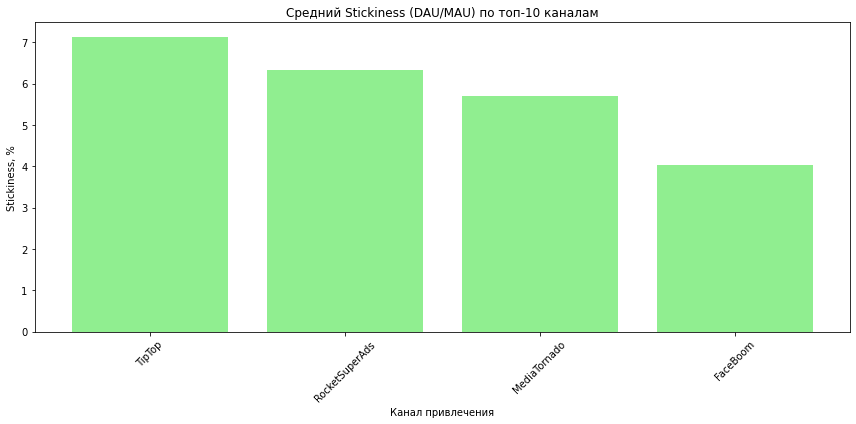

In [30]:
# Расчет Stickiness (DAU/MAU) по каналам
# Сначала подготовим ежедневные и месячные данные
dau_by_channel_date = visits_with_channel.groupby(['date', 'first_channel'])['user_id'].nunique().reset_index()
dau_by_channel_date.columns = ['date', 'channel', 'dau']

mau_by_channel_month = visits_with_channel.groupby(['month', 'first_channel'])['user_id'].nunique().reset_index()
mau_by_channel_month.columns = ['month', 'channel', 'mau']

# Объединяем и рассчитываем Stickiness
dau_by_channel_date['month'] = pd.to_datetime(dau_by_channel_date['date']).dt.to_period('M')
stickiness_data = dau_by_channel_date.merge(mau_by_channel_month, on=['month', 'channel'])
stickiness_data['stickiness'] = (stickiness_data['dau'] / stickiness_data['mau'] * 100).round(2)

# Средний Stickiness по каналам
avg_stickiness = stickiness_data.groupby('channel')['stickiness'].mean().reset_index()
avg_stickiness = avg_stickiness.sort_values('stickiness', ascending=False)

print("Средний Stickiness по каналам:")
display(avg_stickiness.head(15))

# Визуализация Stickiness для топ-каналов
plt.figure(figsize=(12, 6))
top_stickiness = avg_stickiness.head(10)
plt.bar(top_stickiness['channel'], top_stickiness['stickiness'], color='lightgreen')
plt.title('Средний Stickiness (DAU/MAU) по топ-10 каналам')
plt.xlabel('Канал привлечения')
plt.ylabel('Stickiness, %')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

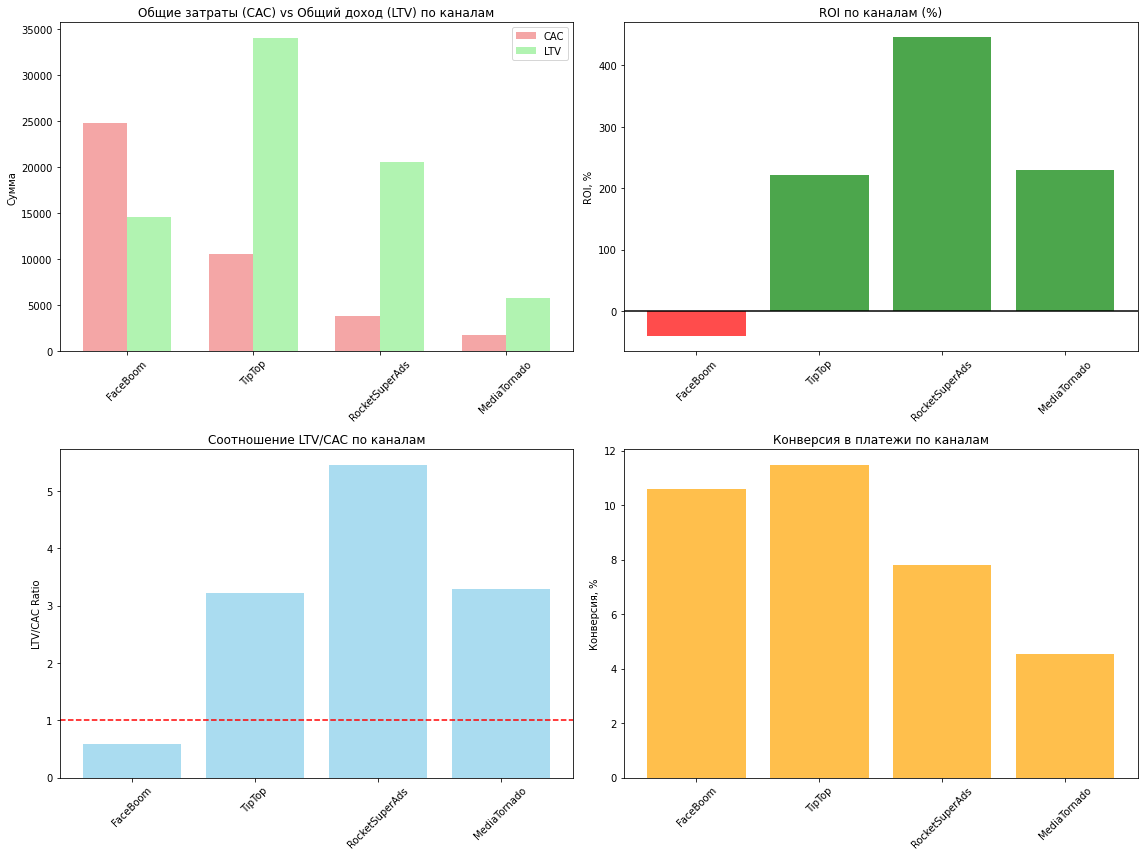

In [31]:
# Топ-15 каналов по объему затрат
top_channels = channel_performance.head(15)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Total CAC vs Total LTV
x = range(len(top_channels))
width = 0.35
ax1.bar(x, top_channels['total_cac'], width, label='CAC', alpha=0.7, color='lightcoral')
ax1.bar([i + width for i in x], top_channels['total_ltv'], width, label='LTV', alpha=0.7, color='lightgreen')
ax1.set_title('Общие затраты (CAC) vs Общий доход (LTV) по каналам')
ax1.set_ylabel('Сумма')
ax1.set_xticks([i + width/2 for i in x])
ax1.set_xticklabels(top_channels['first_channel'], rotation=45)
ax1.legend()

# 2. ROI Percentage
colors = ['red' if x < 0 else 'green' for x in top_channels['roi_percentage']]
bars = ax2.bar(x, top_channels['roi_percentage'], color=colors, alpha=0.7)
ax2.set_title('ROI по каналам (%)')
ax2.set_ylabel('ROI, %')
ax2.set_xticks(x)
ax2.set_xticklabels(top_channels['first_channel'], rotation=45)
ax2.axhline(y=0, color='black', linestyle='-')

# 3. LTV/CAC Ratio
ax3.bar(x, top_channels['ltv_cac_ratio'], alpha=0.7, color='skyblue')
ax3.set_title('Соотношение LTV/CAC по каналам')
ax3.set_ylabel('LTV/CAC Ratio')
ax3.set_xticks(x)
ax3.set_xticklabels(top_channels['first_channel'], rotation=45)
ax3.axhline(y=1, color='red', linestyle='--', label='Точка окупаемости')

# 4. Conversion Rate
ax4.bar(x, top_channels['conversion_rate'], alpha=0.7, color='orange')
ax4.set_title('Конверсия в платежи по каналам')
ax4.set_ylabel('Конверсия, %')
ax4.set_xticks(x)
ax4.set_xticklabels(top_channels['first_channel'], rotation=45)

plt.tight_layout()
plt.show()

In [32]:
# Создаем недельные когорты
profiles['acquisition_week'] = profiles['first_dt'].dt.to_period('W')
df_orders['purchase_week'] = pd.to_datetime(df_orders['event_dt']).dt.to_period('W')

# Создаем таблицу для когортного анализа
cohort_data = profiles[['user_id', 'first_channel', 'acquisition_week', 'cac']].copy()

# Добавляем информацию о покупках
orders_extended = df_orders.merge(profiles[['user_id', 'first_dt', 'acquisition_week']], on='user_id')
orders_extended['lifetime'] = (orders_extended['event_dt'] - orders_extended['first_dt']).dt.days
orders_28d = orders_extended[orders_extended['lifetime'] <= 28]

# Агрегируем данные по пользователям
user_revenue = orders_28d.groupby('user_id')['revenue'].sum().reset_index()
cohort_data = cohort_data.merge(user_revenue, on='user_id', how='left')
cohort_data['revenue'] = cohort_data['revenue'].fillna(0)

In [33]:
# объединение данных
visits_extended = df_visits.merge(profiles[['user_id', 'first_dt', 'first_channel', 'acquisition_week']], on='user_id')
visits_extended['lifetime'] = (visits_extended['session_start'] - visits_extended['first_dt']).dt.days

# Фильтруем визиты с 14 по 28 день
retention_14_28 = visits_extended[(visits_extended['lifetime'] >= 14) & (visits_extended['lifetime'] <= 28)]

# Рассчитываем удержание по каналам и неделям
retention_metrics = retention_14_28.groupby(['first_channel', 'acquisition_week'])['user_id'].nunique().reset_index()
cohort_sizes = profiles.groupby(['first_channel', 'acquisition_week'])['user_id'].nunique().reset_index()

retention_final = retention_metrics.merge(cohort_sizes, on=['first_channel', 'acquisition_week'], suffixes=('_retained', '_total'))
retention_final['retention_rate'] = (retention_final['user_id_retained'] / retention_final['user_id_total'] * 100).round(2)

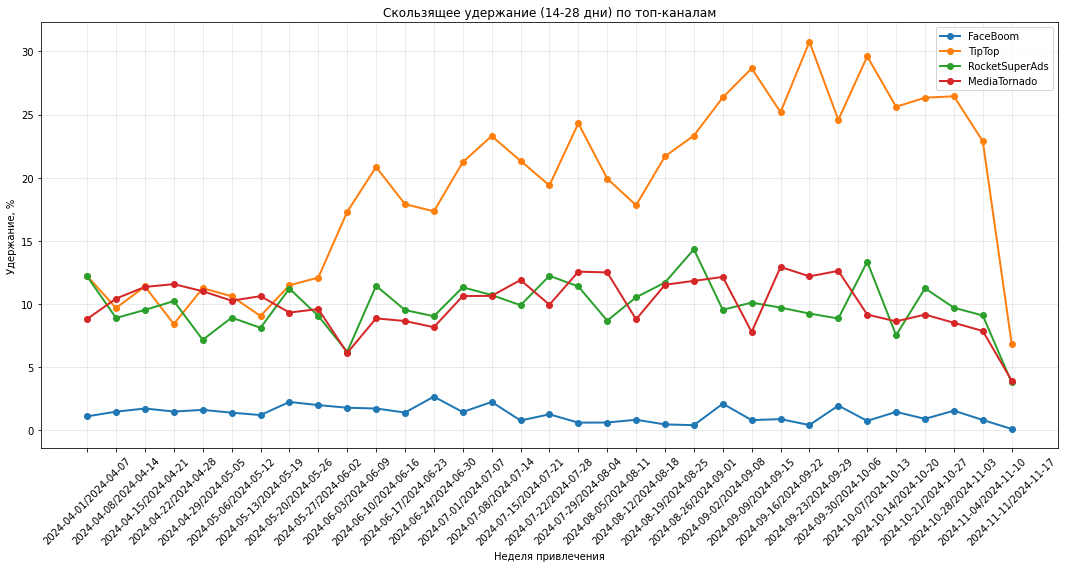

In [34]:
# Визуализация удержания для топ-каналов
top_channels_retention = retention_final.groupby('first_channel')['user_id_total'].sum().nlargest(5).index

plt.figure(figsize=(15, 8))
for channel in top_channels_retention:
    channel_data = retention_final[retention_final['first_channel'] == channel]
    plt.plot(channel_data['acquisition_week'].astype(str), channel_data['retention_rate'], 
             label=channel, marker='o', linewidth=2)

plt.title('Скользящее удержание (14-28 дни) по топ-каналам')
plt.xlabel('Неделя привлечения')
plt.ylabel('Удержание, %')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# объединение для конверсии
orders_extended = df_orders.merge(profiles[['user_id', 'first_dt', 'first_channel', 'acquisition_week']], on='user_id')
orders_extended['lifetime'] = (orders_extended['event_dt'] - orders_extended['first_dt']).dt.days
orders_28d = orders_extended[orders_extended['lifetime'] <= 28]

# Рассчитываем конверсию в покупку
purchasing_users = orders_28d.groupby(['first_channel', 'acquisition_week'])['user_id'].nunique().reset_index()
conversion_data = cohort_sizes.merge(purchasing_users, on=['first_channel', 'acquisition_week'], 
                                   how='left', suffixes=('_total', '_paying'))
conversion_data['conversion_rate'] = (conversion_data['user_id_paying'] / conversion_data['user_id_total'] * 100).fillna(0).round(2)

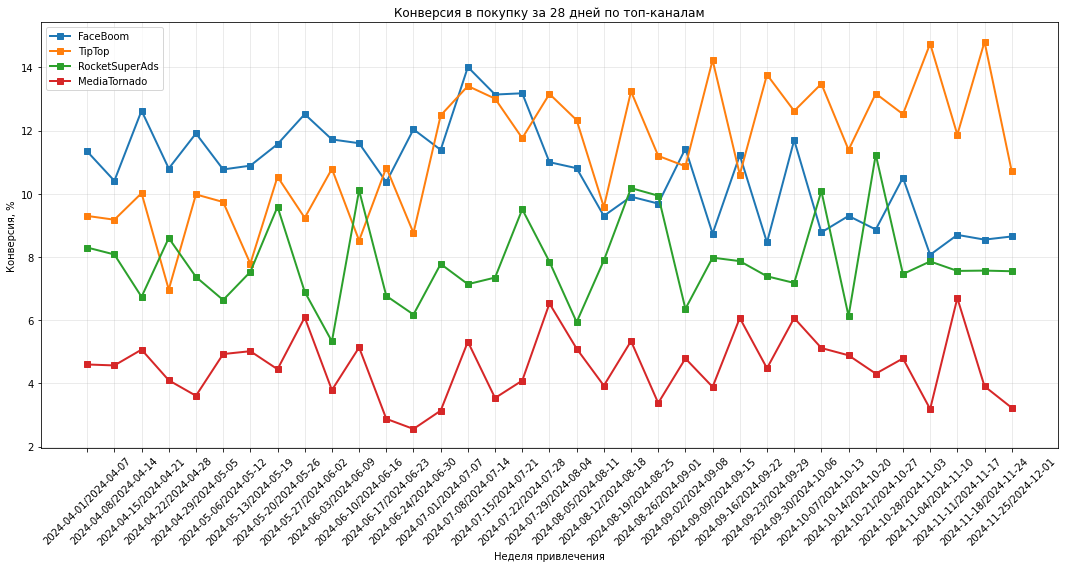

In [36]:
# Визуализация конверсии
plt.figure(figsize=(15, 8))
for channel in top_channels_retention:
    channel_data = conversion_data[conversion_data['first_channel'] == channel]
    plt.plot(channel_data['acquisition_week'].astype(str), channel_data['conversion_rate'], 
             label=channel, marker='s', linewidth=2)

plt.title('Конверсия в покупку за 28 дней по топ-каналам')
plt.xlabel('Неделя привлечения')
plt.ylabel('Конверсия, %')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

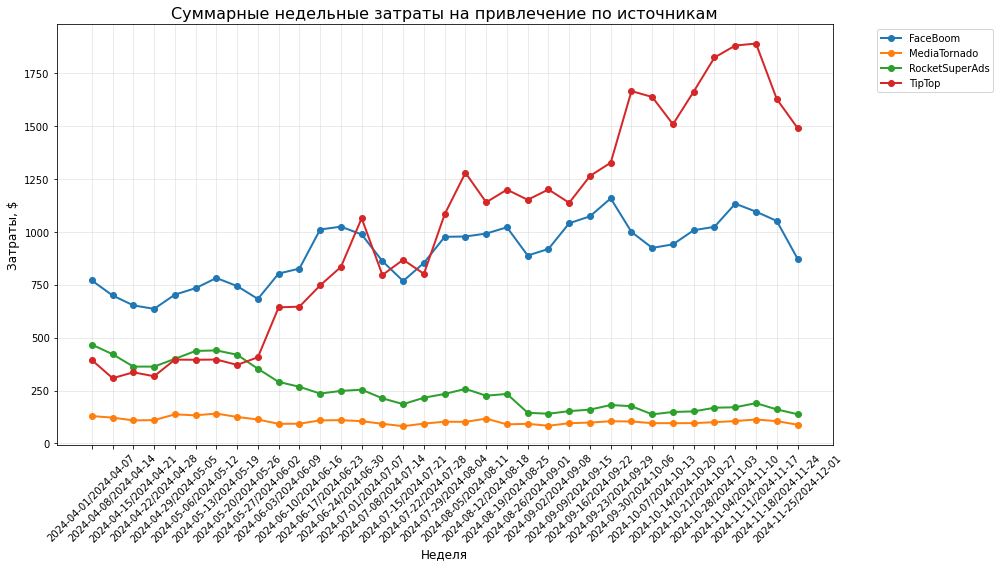

Топ-5 каналов по суммарным затратам после мая 2024:
channel
TipTop            34320.924233
FaceBoom          28864.600830
RocketSuperAds     7130.225000
MediaTornado       3218.746781
Name: costs, dtype: float64


In [37]:
# Анализ недельных затрат по каналам
weekly_costs_by_channel = df_costs.groupby([pd.Grouper(key='dt', freq='W'), 'channel'])['costs'].sum().reset_index()
weekly_costs_by_channel['week'] = weekly_costs_by_channel['dt'].dt.to_period('W')

# Визуализация
plt.figure(figsize=(14, 8))
for channel in weekly_costs_by_channel['channel'].unique():
    channel_data = weekly_costs_by_channel[weekly_costs_by_channel['channel'] == channel]
    plt.plot(channel_data['week'].astype(str), channel_data['costs'], 
             label=channel, marker='o', linewidth=2)

plt.title('Суммарные недельные затраты на привлечение по источникам', fontsize=16)
plt.xlabel('Неделя', fontsize=12)
plt.ylabel('Затраты, $', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Анализ динамики затрат
print("Топ-5 каналов по суммарным затратам после мая 2024:")
recent_costs = weekly_costs_by_channel[weekly_costs_by_channel['week'] >= '2024-05-01']
top_channels = recent_costs.groupby('channel')['costs'].sum().sort_values(ascending=False).head(5)
print(top_channels)

показатели суммарных затрат TipTop и FaceBoom растут с каждой неделей, а остальные два показателя колеблятся в диапазоне начальных затрат.

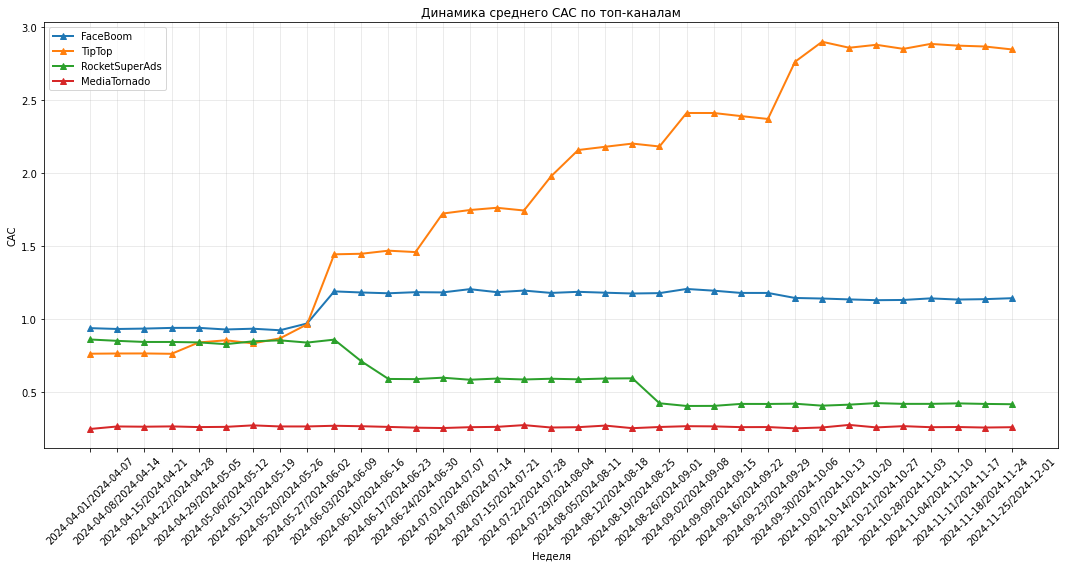

In [38]:
# Анализ затрат по неделям и каналам
weekly_costs = df_costs.groupby([pd.Grouper(key='dt', freq='W'), 'channel'])['costs'].sum().reset_index()
weekly_costs.rename(columns={'dt': 'cost_week'}, inplace=True)
weekly_costs['cost_week'] = weekly_costs['cost_week'].dt.to_period('W')

# Рассчитываем CAC по неделям
weekly_users = profiles.groupby(['acquisition_week', 'first_channel'])['user_id'].nunique().reset_index()
cac_weekly = weekly_costs.merge(weekly_users, left_on=['cost_week', 'channel'], 
                              right_on=['acquisition_week', 'first_channel'], how='left')
cac_weekly['cac'] = cac_weekly['costs'] / cac_weekly['user_id']

# Визуализация динамики CAC
plt.figure(figsize=(15, 8))
for channel in top_channels_retention:
    channel_data = cac_weekly[cac_weekly['channel'] == channel]
    plt.plot(channel_data['cost_week'].astype(str), channel_data['cac'], 
             label=channel, marker='^', linewidth=2)

plt.title('Динамика среднего CAC по топ-каналам')
plt.xlabel('Неделя')
plt.ylabel('CAC')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

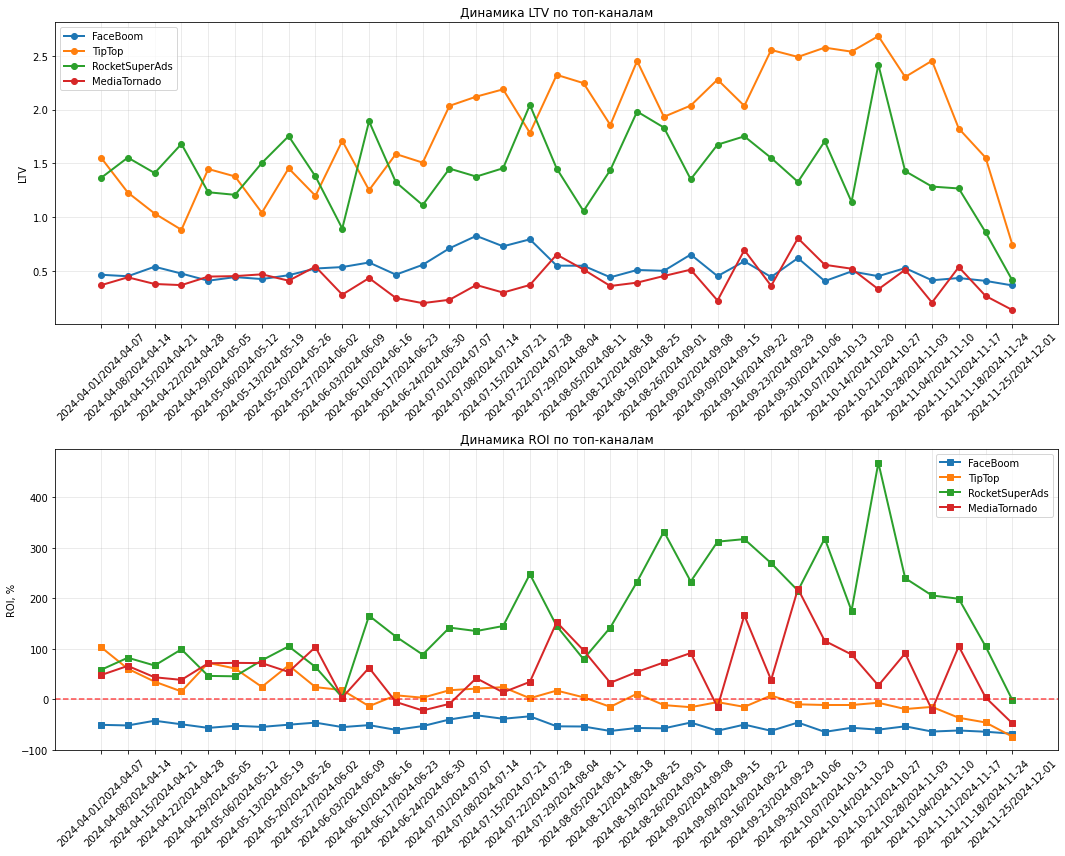

In [39]:
# Рассчитываем LTV по неделям и каналам
weekly_revenue = orders_28d.groupby(['first_channel', 'acquisition_week'])['revenue'].sum().reset_index()
weekly_ltv = weekly_revenue.merge(weekly_users, on=['first_channel', 'acquisition_week'])
weekly_ltv['ltv'] = weekly_ltv['revenue'] / weekly_ltv['user_id']

# Объединяем с CAC для расчета ROI
weekly_metrics = weekly_ltv.merge(cac_weekly[['acquisition_week', 'first_channel', 'cac', 'costs']], 
                                on=['acquisition_week', 'first_channel'])
weekly_metrics['roi'] = (weekly_metrics['ltv'] - weekly_metrics['cac']) / weekly_metrics['cac'] * 100

# Визуализация LTV и ROI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

for channel in top_channels_retention:
    channel_data = weekly_metrics[weekly_metrics['first_channel'] == channel]
    ax1.plot(channel_data['acquisition_week'].astype(str), channel_data['ltv'], 
             label=channel, marker='o', linewidth=2)
    ax2.plot(channel_data['acquisition_week'].astype(str), channel_data['roi'], 
             label=channel, marker='s', linewidth=2)

ax1.set_title('Динамика LTV по топ-каналам')
ax1.set_ylabel('LTV')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

ax2.set_title('Динамика ROI по топ-каналам')
ax2.set_ylabel('ROI, %')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Конверсия в покупку колеблится примерно в одном диапазоне и отклонения не критичны. TipTop требует срочной оптимизации - слишком дорогое привлечение, но при этом самое высокое удержание. По графику ROI видно что TipTop и faceboom имеют отрицательные показатели, а RocketSuperAds имеет хорошие показатели. По таблице LTV видно , что TipTop и RocketSuperAds отличаются более высокими показателями относительно двух других.

## Анализ периода окупаемости маркетинговых вложений



In [40]:
# Расширяем период анализа до 70 дней (10 недель)
orders_extended = df_orders.merge(profiles[['user_id', 'first_dt', 'first_channel', 'acquisition_week']], on='user_id')
orders_extended['lifetime'] = (orders_extended['event_dt'] - orders_extended['first_dt']).dt.days
orders_70d = orders_extended[orders_extended['lifetime'] <= 70]

# Создаем недельные интервалы для анализа ROI
weekly_roi_data = []

for weeks in range(1, 11):  # Анализируем с 1 по 10 неделю
    days_limit = weeks * 7
    orders_period = orders_extended[orders_extended['lifetime'] <= days_limit]
    
    # Рассчитываем LTV для периода
    period_revenue = orders_period.groupby(['first_channel', 'acquisition_week'])['revenue'].sum().reset_index()
    period_ltv = period_revenue.merge(weekly_users, on=['first_channel', 'acquisition_week'])
    period_ltv['ltv'] = period_ltv['revenue'] / period_ltv['user_id']
    
    # Объединяем с CAC для расчета ROI
    period_metrics = period_ltv.merge(cac_weekly[['acquisition_week', 'first_channel', 'cac']], 
                                    on=['acquisition_week', 'first_channel'])
    period_metrics['roi'] = (period_metrics['ltv'] - period_metrics['cac']) / period_metrics['cac'] * 100
    period_metrics['weeks'] = weeks
    
    weekly_roi_data.append(period_metrics)

# Объединяем все данные
extended_roi_analysis = pd.concat(weekly_roi_data)

In [41]:
# Создаем сводную таблицу по эффективности каналов за 28 дней
channel_summary_28d = weekly_metrics.groupby('first_channel').agg({
    'cac': 'mean',
    'ltv': 'mean', 
    'roi': 'mean',
    'user_id': 'sum',
    'costs': 'sum',
    'revenue': 'sum'
}).round(2)

channel_summary_28d['ltv_cac_ratio'] = channel_summary_28d['ltv'] / channel_summary_28d['cac']
channel_summary_28d['profitability'] = np.where(channel_summary_28d['roi'] >= 0, 'Окупаемый', 'Убыточный')

print("Анализ каналов за 28 дней:")
display(channel_summary_28d.sort_values('costs', ascending=False))

Анализ каналов за 28 дней:


,cac,ltv,roi,user_id,costs,revenue,ltv_cac_ratio,profitability
first_channel,,,,,,,,
TipTop,1.89,1.84,8.36,18118,35676.61,34036.53,0.973545,Окупаемый
FaceBoom,1.11,0.52,-53.21,28401,31621.37,14605.85,0.468468,Убыточный
RocketSuperAds,0.60,1.44,162.60,14257,8744.38,20561.27,2.400000,Окупаемый
MediaTornado,0.26,0.41,56.08,14080,3688.94,5782.65,1.576923,Окупаемый


In [42]:
# Определяем каналы, которые не окупились за 4 недели
unprofitable_channels = channel_summary_28d[channel_summary_28d['roi'] < 10].index.tolist()
print("Убыточные каналы:", unprofitable_channels)

# Фильтруем данные для убыточных каналов
unprofitable_data = extended_roi_analysis[extended_roi_analysis['first_channel'].isin(unprofitable_channels)]

Убыточные каналы: ['FaceBoom', 'TipTop']


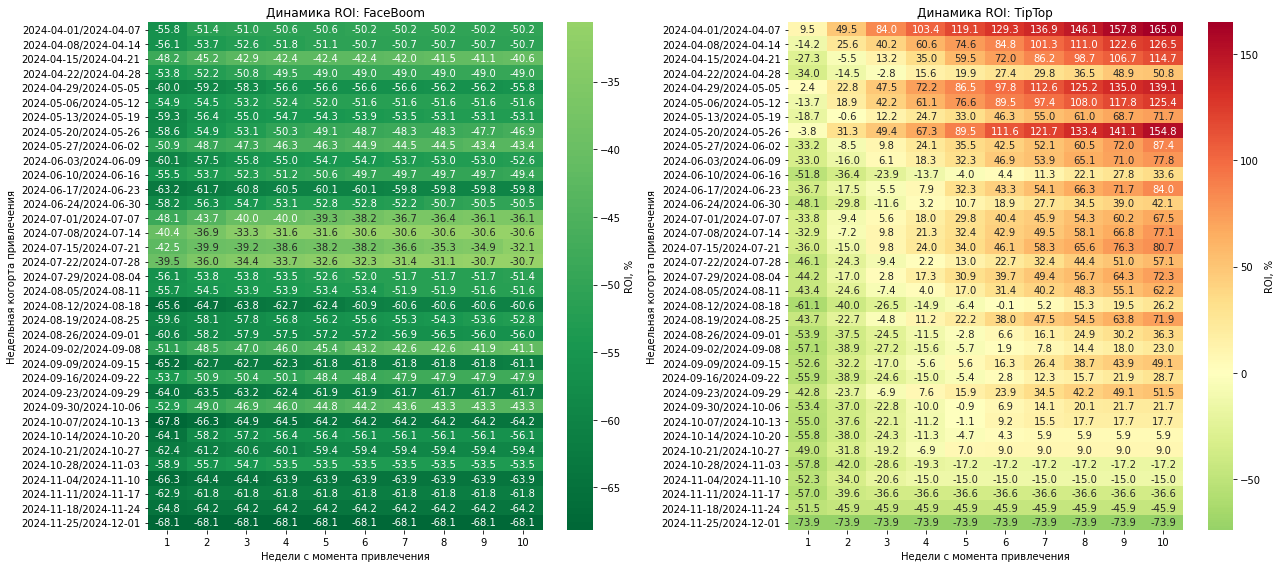

In [43]:
# Подготовка данных для тепловой карты - группируем по каналу и неделе
heatmap_data = unprofitable_data.pivot_table(
    index=['acquisition_week', 'first_channel'],  # добавляем канал в индекс
    columns='weeks',
    values='roi',
    aggfunc='mean'
).reset_index()

# Создаем мультииндекс для отображения двух каналов
heatmap_data_multi = heatmap_data.set_index(['acquisition_week', 'first_channel'])

# Альтернативный вариант: две отдельные тепловые карты для каждого канала
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for i, channel in enumerate(unprofitable_channels):
    channel_data = unprofitable_data[unprofitable_data['first_channel'] == channel]
    channel_heatmap = channel_data.pivot_table(
        index='acquisition_week',
        columns='weeks',
        values='roi',
        aggfunc='mean'
    )
    
    sns.heatmap(channel_heatmap, 
                annot=True, 
                fmt='.1f', 
                cmap='RdYlGn_r',
                center=0,
                ax=axes[i],
                cbar_kws={'label': 'ROI, %'})
    
    axes[i].set_title(f'Динамика ROI: {channel}')
    axes[i].set_xlabel('Недели с момента привлечения')
    axes[i].set_ylabel('Недельная когорта привлечения')

plt.tight_layout()
plt.show()

Среднее время окупаемости по каналам (недель):
first_channel
TipTop       5.1
FaceBoom    12.0
Name: breakeven_week, dtype: float64


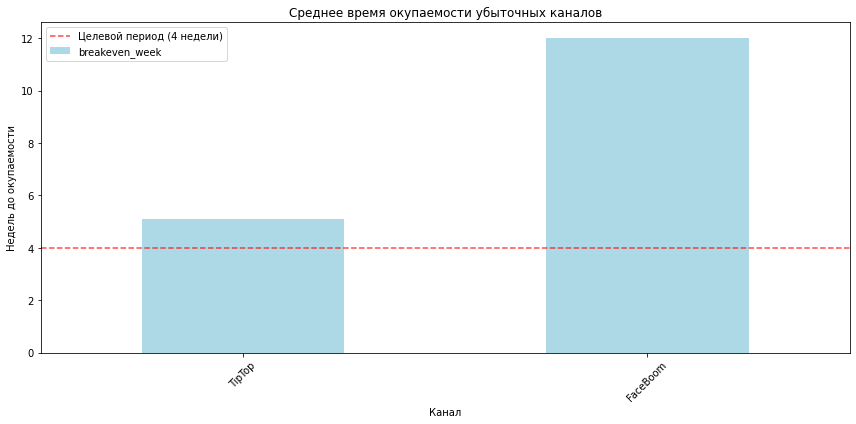

In [44]:
# Находим неделю окупаемости для каждой когорты
breakeven_analysis = unprofitable_data.groupby(['acquisition_week', 'first_channel']).apply(
    lambda x: x[x['roi'] >= 0]['weeks'].min() if any(x['roi'] >= 0) else float('inf')
).reset_index()
breakeven_analysis.columns = ['acquisition_week', 'first_channel', 'breakeven_week']

# Заменяем бесконечность на 12 (если не окупились за 10 недель)
breakeven_analysis['breakeven_week'] = breakeven_analysis['breakeven_week'].replace(float('inf'), 12)

# Анализируем среднее время окупаемости
avg_breakeven = breakeven_analysis.groupby('first_channel')['breakeven_week'].mean().round(1)
print("Среднее время окупаемости по каналам (недель):")
print(avg_breakeven.sort_values())

# Визуализация времени окупаемости
plt.figure(figsize=(12, 6))
avg_breakeven.sort_values().plot(kind='bar', color='lightblue')
plt.axhline(y=4, color='red', linestyle='--', alpha=0.7, label='Целевой период (4 недели)')
plt.title('Среднее время окупаемости убыточных каналов')
plt.xlabel('Канал')
plt.ylabel('Недель до окупаемости')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

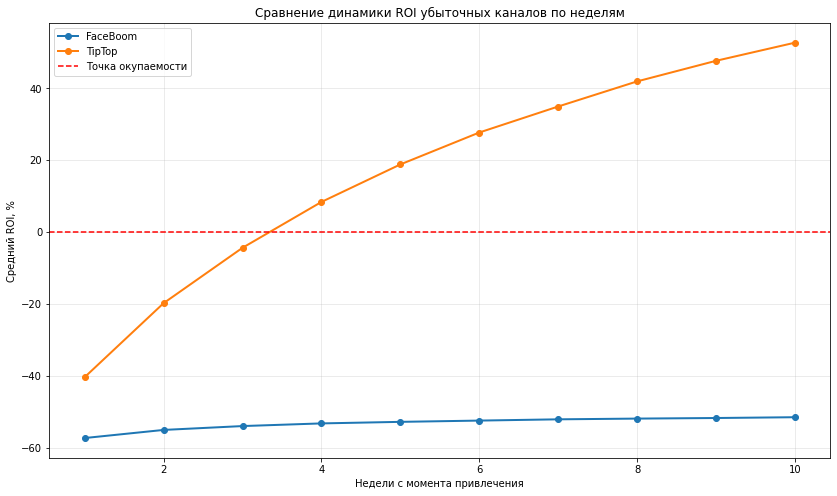

In [45]:
# Анализ среднего ROI по неделям для убыточных каналов
plt.figure(figsize=(14, 8))
for channel in unprofitable_channels:
    channel_avg = unprofitable_data[unprofitable_data['first_channel'] == channel].groupby('weeks')['roi'].mean()
    plt.plot(channel_avg.index, channel_avg.values, 
             label=channel, marker='o', linewidth=2)

plt.axhline(y=0, color='red', linestyle='--', label='Точка окупаемости')
plt.title('Сравнение динамики ROI убыточных каналов по неделям')
plt.xlabel('Недели с момента привлечения')
plt.ylabel('Средний ROI, %')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [46]:
# Сводная таблица по окупаемости
breakeven_summary = pd.DataFrame({
    'avg_breakeven_weeks': avg_breakeven,
    'cac_28d': channel_summary_28d['cac'],
    'ltv_28d': channel_summary_28d['ltv'],
    'roi_28d': channel_summary_28d['roi']
})

# Добавляем прогноз ROI за 12 недель
roi_12w = unprofitable_data[unprofitable_data['weeks'] == 10].groupby('first_channel')['roi'].mean()
breakeven_summary['roi_12w_projected'] = roi_12w

print("Комплексный анализ окупаемости:")
display(breakeven_summary.sort_values('avg_breakeven_weeks'))

Комплексный анализ окупаемости:


,avg_breakeven_weeks,cac_28d,ltv_28d,roi_28d,roi_12w_projected
first_channel,,,,,
TipTop,5.1,1.89,1.84,8.36,52.637093
FaceBoom,12.0,1.11,0.52,-53.21,-51.485900
MediaTornado,NaN,0.26,0.41,56.08,NaN
RocketSuperAds,NaN,0.60,1.44,162.60,NaN


## Выводы и рекомендации




Канал TipTop имеет хорошие показатели RR, показатель удержания, конверсию в покупку и LTV, но имеет один недостаток CAC с начала периода вырос почти в 3 раза, следовательно вывод один , нужно оптимизировать затраты на маркетинг через этот канал.
MediaTornado имеет везде достаточно средние показатели и самые маленькие затраты на маркетинг,следовательно это стабильный канал на который следует обратить внимание и перераспредилить бюджет.
RocketSuperAds перспективный канал привлечения с хорошими показателями и я думаю стоит увеличить затраты на маркетинг через этот канал.
FaceBoom убыточный канал, имеет огромную аудиторию, но у них низкая заинтересованность, удержание никакущее по показателям, но зато конверсия в покупку очень высокая, также затраты на марткетинг немного увеличились,но не принесли никаких результатов, возможно сделали даже хуже.

**Вывод: оптимизировать затраты на убыточные каналы FaceBoom и TipTop, попробовать изменить что то в рекламе чтобы заинтересовать аудиторию канала FaceBoom для повышения показателей окупаемости, и профинансировать стабильные и перспективные каналы RocketSuperAds и MediaTornado.** 